<a href="https://colab.research.google.com/github/jhymel/2D-Ising-Model/blob/main/Ising_with_field.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
from numpy.random import randint as randint
from numpy.random import rand as rand
import matplotlib.pyplot as plt

In [39]:
#J = 0.4407
J=1.0
beta = 0.5  # beta = 1 / (kB * T), work in these units
N = 20   # 2D lattice is N x N
Ncycles = int(1000000/(20*20)) # 2500 Montecarlo cycles
#Nsteps = Ncycles*(N*N) # number of Montecarlo steps
Nsteps = 100000
n_snap = 4 # number of snapshots to store, must be even number (see code below)
freq_store = Nsteps/n_snap # frequency to store trajectory snapshot
m_start = 1  # -1 = start all spin down, 0 = start random, +1 = start all spin up
h = 0
equil_fraction = 0.3 # throw out this fraction of initial simulation
Nequil = int(equil_fraction*Nsteps)
lattice_spin=[]
freq_average = N**2

In [40]:
# This gives the energy for spin Si, with lattice indices i_x, i_y, remember
# Python indexing starts at 0, so 0 <= i_x, i_y <= (N-1)
def Energy_Si(i_x,i_y):
    Si = lattice_spin[i_x][i_y] # this is either up (+1) or down (-1)

    # here we use a trick for periodic boundary conditions, i.e. so that
    # spins on the edge of the lattice interact with spins at the start of
    # the lattice.  To do this, we use the modulo operator "%", which gives
    # remainder, and only affects the beginning and end spins in our usage
    # we want the beginning spin 0 to interact with the last spin, N-1
    # so we use the fact that N % N = 0, and (-1) % N = N - 1

    Ei = 0.0 # initialize

    Ei = Ei - J * Si * lattice_spin[(i_x+1)%N][i_y] # interaction with spin to the right 
    Ei = Ei - J * Si * lattice_spin[(i_x-1)%N][i_y] # interaction with spin to the left 
    Ei = Ei - J * Si * lattice_spin[i_x][(i_y+1)%N] # interaction with spin above 
    Ei = Ei - J * Si * lattice_spin[i_x][(i_y-1)%N] # interaction with spin below 

    return Ei


In [41]:
# This gives the total system energy by summing up all pairwise spin energies
def Energy_Total():
    E_tot = 0.0
    for i in range(N):
        for j in range(N):
            E_tot += Energy_Si(i,j)/2
            E_tot += -h*lattice_spin[i][j]

    return E_tot

In [42]:
plt.ioff()
fig, axs = plt.subplots(int(n_snap/2), int(n_snap/2), figsize=(10,10), dpi=100)
plt.close(fig)

# Don't need to worry about the details here, just use it!
def Store_Snapshot( i_snap, i_step ):
    # we need to turn the "lattice_spin" list into a numpy array for plotting
    spin_array = np.array(lattice_spin)
    X, Y = np.meshgrid(range(N), range(N))
    
    ax = axs[(int(i_snap-1)//2)][(i_snap-1)%2]
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.pcolormesh(X, Y, spin_array, cmap=plt.cm.RdBu)
    ax.set_title('Moves=%d'%i_step)

In [43]:
if m_start == -1:  # initialize all spin down
    lattice_spin=[[-1 for i_x in range(N)] for i_y in range(N)]
elif m_start == 0: # initialize all random, this will fill either -1 or 1, since 2*randint(2) gives either 0 or 2.
    lattice_spin=[[(2*randint(2)-1) for i_x in range(N)] for i_y in range(N)]
elif m_start == 1: # initialize all spin up
    lattice_spin=[[1 for i_x in range(N)] for i_y in range(N)]
else:
    print (" value of m_start not recognized ")
    sys.exit(0)

-744.0
0.9146664285713768
0.9146664285713768
-1.7621199999999992
3.1119188


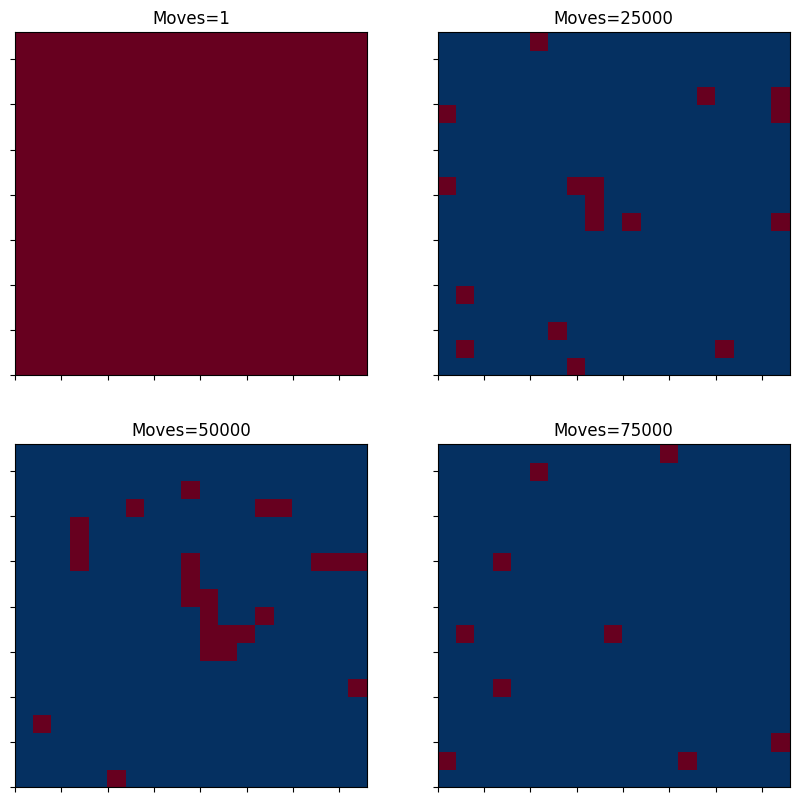

In [44]:
#********************** Now use Monte Carlo to flip spins, run Nsteps number of MC moves
accept_count= 0 # keep track of how many moves are accepted
snap_count=0  # number of snapshots stored
mag_t_sum = 0 # total magnetization across timesteps 
energy_t_sum = 0 # total energy across timesteps
energy_squared_t_sum = 0 # total energy^2 across timesteps

for i_step in range(Nsteps):
    # randomly choose spin, given by lattice position i_x, i_y
    i_x = randint(0,N) # this give 0<= i_x <= N-1
    i_y = randint(0,N) # same comment
    E_i = Energy_Si(i_x,i_y) # energy of spin in current state
    E_f = -E_i   # flipping spin gives negative energy
    deltaE = E_f - E_i + h*2*lattice_spin[i_x][i_y] # energy change for spin flip

    # Metropolic Algorithm for accepting moves (detailed balance)
    if deltaE < 0:  # accept move if it lowers system energy
         lattice_spin[i_x][i_y] *= -1 # flip spin by multiplying current value by -1
         accept_count += 1  #increment
    else:
         boltz=np.exp(-beta*deltaE)# boltzmann factor, use exponential from numpy  
         randfrac=rand() # random real between [0,1)
         if randfrac < boltz:  # accept move with this probability
              lattice_spin[i_x][i_y] *= -1
              accept_count += 1   #increment
    
    if i_step + 1 > Nequil:
        mag_t_sum += np.sum(np.array(lattice_spin))/(N**2)
    #********** ADD Any averaging here .... ****************
    # need to define an averaging frequency call freq_average
    if (i_step % freq_average) == 0:
        # add to average
        energy_t_sum += Energy_Total()/(N**2)
        energy_squared_t_sum += (Energy_Total()*Energy_Total())/(N**4)
        
    # decide if we want to store snapshot, use modulo operator
    # for some reason, the initial snapshot colors are weird, so skip this one...
    if (i_step > 0 ) and ( (i_step == 1) or (i_step % freq_store == 0) ):
         snap_count+=1
         flag = Store_Snapshot(snap_count,i_step) 

mag_t_sum /= (Nsteps-Nequil)
mag_per_spin = mag_t_sum
energy_t_sum /= (Nsteps/freq_average)
energy_per_spin = energy_t_sum
energy_squared_t_sum /= (Nsteps/freq_average)
energy_squared_per_spin = energy_squared_t_sum
print(Energy_Total())
print(mag_t_sum)
print(mag_per_spin)
print(energy_per_spin)
print(energy_squared_per_spin)

fig

In [ ]:

print ( "fraction of moves accepted was:", frac_accept )


NameError: ignored

In [ ]:
def run_sim(beta,J):
    #********************** Now use Monte Carlo to flip spins, run Nsteps number of MC moves
    accept_count= 0 # keep track of how many moves are accepted
    snap_count=0  # number of snapshots stored
    mag_t_sum = 0 # total magnetization across timesteps 
    energy_t_sum = 0 # total energy across timesteps
    energy_squared_t_sum = 0 # total energy^2 across timesteps

    for i_step in range(Nsteps):
        # randomly choose spin, given by lattice position i_x, i_y
        i_x = randint(0,N) # this give 0<= i_x <= N-1
        i_y = randint(0,N) # same comment
        E_i = Energy_Si(i_x,i_y) # energy of spin in current state
        E_f = -E_i   # flipping spin gives negative energy
        deltaE = E_f - E_i # energy change for spin flip

        # Metropolic Algorithm for accepting moves (detailed balance)
        if deltaE < 0:  # accept move if it lowers system energy
             lattice_spin[i_x][i_y] *= -1 # flip spin by multiplying current value by -1
             accept_count += 1  #increment
        else:
            boltz=np.exp(-beta*deltaE)# boltzmann factor, use exponential from numpy  
            randfrac=rand() # random real between [0,1)
            if randfrac < boltz:  # accept move with this probability
                  lattice_spin[i_x][i_y] *= -1
                  accept_count += 1   #increment
    
        if i_step + 1 > Nequil:
            mag_t_sum += np.sum(np.array(lattice_spin))/(N**2)
        #********** ADD Any averaging here .... ****************
        # need to define an averaging frequency call freq_average
        if (i_step % freq_average) == 0:
            # add to average
            energy_t_sum += Energy_Total()/(N**2)
            energy_squared_t_sum += (Energy_Total()*Energy_Total())/(N**4)
        
        # decide if we want to store snapshot, use modulo operator
        # for some reason, the initial snapshot colors are weird, so skip this one...
        if (i_step > 0 ) and ( (i_step == 1) or (i_step % freq_store == 0) ):
            snap_count+=1
            flag = Store_Snapshot(snap_count,i_step) 

    mag_t_sum /= (Nsteps-Nequil)
    mag_per_spin = mag_t_sum
    energy_t_sum /= (Nsteps/freq_average)
    energy_per_spin = energy_t_sum
    energy_squared_t_sum /= (Nsteps/freq_average)
    energy_squared_per_spin = energy_squared_t_sum
    print(beta,mag_per_spin,energy_per_spin,energy_squared_per_spin,'\t')

In [ ]:
BJ_list = [0.1,0.2,0.3,0.4,0.42,0.44,0.445,0.45,0.455,0.46,0.48,0.5,0.52,0.54,0.56,0.6,0.7,0.8,0.9]
val_list = np.linspace(0.44,0.444,30)

In [ ]:
for i in val_list:
    beta,J = (i,1)
    run_sim(beta,J)
    run_sim(beta,J)
    run_sim(beta,J)
    run_sim(beta,J)

0.44 0.3985507071428421 -1.4300080000000006 2.065498000000003 	
0.44 0.59528615714289 -1.4018000000000004 1.9876371200000078 	
0.44 0.716020835714367 -1.454444000000001 2.1333969200000023 	
0.44 0.5488581857144568 -1.4020479999999997 1.9876343200000057 	
0.4401379310344828 0.7305594999997449 -1.475044000000001 2.192308520000001 	
0.4401379310344828 0.6453359714285493 -1.4298760000000037 2.065803240000008 	
0.4401379310344828 0.6974790571428992 -1.4562479999999984 2.1402335199999967 	
0.4401379310344828 0.7484042714285482 -1.4558039999999994 2.1379510000000015 	
0.4402758620689655 0.6925314000001301 -1.4444200000000023 2.1064688400000136 	
0.4402758620689655 -0.5221834357142414 -1.4489120000000066 2.119193600000006 	
0.4402758620689655 0.691094649999964 -1.4526560000000022 2.1297368799999994 	
0.4402758620689655 0.7401070642856045 -1.4706200000000034 2.178019160000003 	
0.4404137931034483 -0.47118605714277356 -1.4463680000000005 2.1141038400000003 	
0.4404137931034483 0.641455399999836 